# Importing libraries

In [46]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import balanced_accuracy_score

from fastquant import backtest, get_stock_data
from fastquant.strategies import TernaryStrategy
import matplotlib.pyplot as plt


# Importing data and last cleanup

In [76]:
df = pd.read_csv("cleaned_data.csv")
df

,Date,Close,Var. (%),Open,Low,High,Volume,Support,Resistance,Hammer,...,MACD LINE,SIGNAL LINE,HISTOGRAM,ZeroCross,SignalCross,Decision14,Decision28,Decision10,Decision50,Decision5
0,2016-01-26,4.20,-4.76,4.23,4.12,4.31,"302,717,532",0,0,0.0,...,0.000000,0.000000,0.000000,NaN,NaN,-1,-1,-1,-1,-1
1,2016-01-27,4.57,8.81,4.22,4.16,4.64,"352,368,579",0,0,0.0,...,0.000000,0.000000,0.000000,NaN,NaN,-1,-1,-1,-1,-1
2,2016-01-28,4.60,0.66,4.67,4.35,5.13,"618,332,894",0,0,0.0,...,0.000000,0.000000,0.000000,NaN,NaN,-1,-1,-1,-1,-1
3,2016-01-29,4.84,5.22,4.70,4.52,4.86,"439,826,229",0,0,0.0,...,0.000000,0.000000,0.000000,NaN,NaN,-1,-1,-1,-1,-1
4,2016-02-01,4.72,-2.48,4.74,4.66,4.86,"245,882,432",0,0,0.0,...,0.000000,0.000000,0.000000,NaN,NaN,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037,2020-04-03,15.34,-1.10%,16.30,14.93,16.36,"142,01M",0,0,0.0,...,-2.297545,-3.066222,0.768677,0.0,1.0,-1,-1,-1,-1,-1
1038,2020-04-06,15.77,2.80%,16.05,15.18,16.10,"122,54M",0,0,0.0,...,-2.031713,-2.859320,0.827607,0.0,1.0,-1,-1,-1,-1,-1
1039,2020-04-07,16.40,3.99%,16.61,16.34,17.07,"139,72M",0,0,0.0,...,-1.750030,-2.637462,0.887432,0.0,1.0,-1,-1,-1,-1,-1
1040,2020-04-08,17.32,5.61%,16.50,16.40,17.53,"114,58M",0,0,0.0,...,-1.436005,-2.397171,0.961166,0.0,1.0,-1,-1,-1,-1,-1


In [77]:
def feature_decision_selection(df,features, decision):
    """Reorganizing the dataset with the features first and the decision at the last column
    df = dataset
    features = input to the model
    decision = target value 
    """
    df2 = df.loc[df[decision] != -1] #removing the data where decisions are missing
    df2 = df2[features + [decision]]
    return df2

In [78]:
dataframes = [] #will contain all different datasets
features = ['Date','Support', 'Resistance','Hammer', 'ZeroCross', 'SignalCross']
decisions = ['Decision5', 'Decision10','Decision14', 'Decision28', 'Decision50']
for decision in decisions:
    dataframes.append(feature_decision_selection(df,features,decision))

# Splitting the data

In [90]:
def data_split(dataframes):
    """ split the dataframe in dataframes in testing and training set
        
        dataframes = array of dataframe
    """
    split_data = []
    for df in dataframes:
        train = df[0:692] #from 2016 to 2018
        test = df[692:] #from 2019 to 2020
        x_train = train.iloc[:,1:-1].to_numpy() #excluding the date column
        x_test = test.iloc[:,1:-1].to_numpy()
        y_train = train.iloc[:,-1].to_numpy()
        y_test = test.iloc[:,-1].to_numpy()
        split_data.append([x_train,x_test,y_train,y_test])

    return split_data

In [92]:
model_data = data_split(dataframes)

# Getting the predictions

In [93]:
def predictors(data,model):
    """train and test the model on the data
    
        data = testing and training data
        model = model used
    """
    predictions = []
    for d in data:
        x_train = d[0]
        x_test = d[1]
        y_train = d[2]
        y_test = d[3]
        model.fit(x_train,y_train)
        pred = model.predict(x_test)
        predictions.append([pred,balanced_accuracy_score(y_test,pred) , confusion_matrix(y_test,pred)])
        
    return predictions

In [96]:
prediction_info = predictors(model_data, ComplementNB()) #look at index 0 of each array for predictions

# Adding hold to the predictions
## repeated signals will be transformed to hold
## to be consistent with the fastquant libraries, sell = -1, hold = 0, buy = 1

In [107]:
def sell_transform(data):
    for i in range(len(data)):
        data[i][0] = np.where(data[i][0] == 0, -1, data[i][0])

In [108]:
sell_transform(prediction_info)

In [55]:
def add_hold(arr):
    last_decision = arr[0]
    decision = [last_decision]
    for i in range(1,len(arr)):
        if arr[i] == last_decision:
            decision.append(0)
        else:
            last_decision = arr[i]
            decision.append(last_decision)
    return decision

In [110]:
def final_decision(data):
    for d in data:
        d[0] = add_hold(d[0])

In [111]:
final_decision(prediction_info)

In [57]:
fastquant_data = df[692:]

In [58]:
fastquant_data['custom'] = pred2

In [121]:
prediction_info

[[[1,
   0,
   0,
   -1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   -1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   -1,
   0,
   0,
   0,
   1,
   -1,
   0,
   0,
   0,
   0,
   0,
   1,
   -1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   -1,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   -1,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   -1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   -1,
   0,
   0,
   1,
   -1,
   1,
   0,


In [122]:
dataframes

[            Date  Support  Resistance  Hammer  ZeroCross  SignalCross  \
 33    2016-03-15        0           0     0.0        1.0          1.0   
 34    2016-03-16        1           0     0.0        1.0          1.0   
 35    2016-03-17        0           0     0.0        1.0          1.0   
 36    2016-03-18        0           0     0.0        1.0          1.0   
 37    2016-03-21        0           0     0.0        1.0          1.0   
 ...          ...      ...         ...     ...        ...          ...   
 1032  2020-03-27        0           0     0.0        0.0          1.0   
 1033  2020-03-30        0           0     0.0        0.0          1.0   
 1034  2020-03-31        0           0     0.0        0.0          1.0   
 1035  2020-04-01        0           0     0.0        0.0          1.0   
 1036  2020-04-02        0           1     0.0        0.0          1.0   
 
       Decision5  
 33            1  
 34            1  
 35            0  
 36            0  
 37            

# Pre processing the data according to fastquant requirements

In [120]:
def fastquant_preprocess(data,pred):
    """Put data as an index and add the prediction column 
    
        data = dataframes used
        pred = multidimensional array of prediction, accuracy and confusion matrix
    """
    fq_data = []
    

In [59]:
#setting the data as indexes 
fastquant_data["dt"] = fastquant_data["Date"]
fastquant_data.drop("Date", axis = 1)
fastquant_data.set_index("dt", inplace=True)

In [60]:
#keeping the relevant data
fastquant_data = fastquant_data[['Close','Open','Low','High', 'custom']]

# Backtesting the strategy

In [61]:
res = backtest(TernaryStrategy,fastquant_data, init_cash = 2342, plot = False, return_history = True,verbose = False)

In [62]:
res[1].keys()

dict_keys(['orders', 'periodic', 'indicators'])

In [63]:
res[1]['periodic']

,strat_id,strat_name,dt,portfolio_value,cash,return
0,0,,2019-01-02,2342.000000,2342.000000,NaN
1,0,,2019-01-03,2381.040650,6.030650,0.016670
2,0,,2019-01-04,2387.970650,6.030650,0.002910
3,0,,2019-01-07,2425.590650,6.030650,0.015754
4,0,,2019-01-08,2392.705325,2392.705325,-0.013558
...,...,...,...,...,...,...
307,0,,2020-03-27,2973.071925,7.171925,-0.082444
308,0,,2020-03-30,2990.911925,7.171925,0.006001
309,0,,2020-03-31,3126.941925,7.171925,0.045481
310,0,,2020-04-01,3196.071925,7.171925,0.022108


In [64]:
res[1]['indicators']

,strat_id,strat_name,dt,CustomIndicator
0,0,,2019-01-02,1.0
1,0,,2019-01-03,0.0
2,0,,2019-01-04,0.0
3,0,,2019-01-07,-1.0
4,0,,2019-01-08,0.0
...,...,...,...,...
307,0,,2020-03-27,0.0
308,0,,2020-03-30,0.0
309,0,,2020-03-31,0.0
310,0,,2020-04-01,0.0


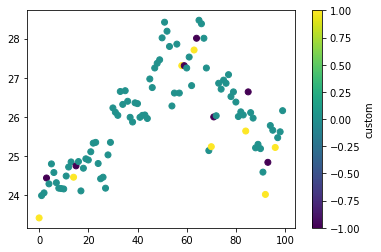

In [65]:
plt.scatter(range(100), fastquant_data.iloc[0:100]['Close'], c=fastquant_data.iloc[0:100]['custom'])
plt.colorbar(label='custom') # 0 = hold, -1 = sell, 1 = buy 
plt.show()

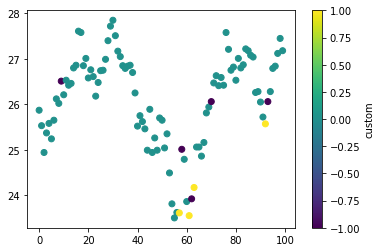

In [66]:
plt.scatter(range(100), fastquant_data.iloc[100:200]['Close'], c=fastquant_data.iloc[100:200]['custom'])
plt.colorbar(label='custom') # 0 = hold, -1 = sell, 1 = buy 
plt.show()

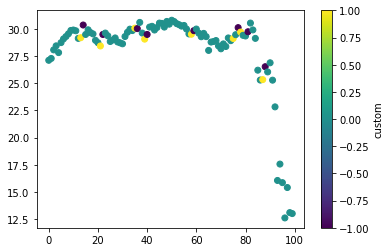

In [67]:
plt.scatter(range(100), fastquant_data.iloc[200:300]['Close'], c=fastquant_data.iloc[200:300]['custom'])
plt.colorbar(label='custom') # 0 = hold, -1 = sell, 1 = buy 
plt.show()